# Cleaning the What's Cooking Dataset
## Ingredients
Before we can get started, we need to standardize our ingredients.
As of now, one-hot coding would be unreliable if the same ingredients cannot be interpreted as such.

For example:
- "skinless chicken breasts"
- "free range chicken breasts"
- "cooked chicken breasts"

Since our goal is to collect information on what ingredients constitute to what cuisine, these must all be canonicalized as "chicken breast" or similar.

In [17]:
# First, we have to collect our ingredients from the hypergraph.
# The ingredients can be found in the "node-data" of our hypergraph.

import json
import os

dataset_path = "dataset"
# Load the dataset
with open(os.path.join(dataset_path, 'kaggle-whats-cooking.json'), 'r') as f:
    data = json.load(f)

# Extract ingredients from node-data
ingredients_list = []
for key, value in data['node-data'].items():
    ingredients_list.append({
        'id': key,
        'ingredient': value['name'],
        'canonicalized': ''
    })

# Save to new JSON file
with open(os.path.join(dataset_path, 'ingredients.json'), 'w') as f:
    json.dump(ingredients_list, f, indent=2)

print(f"Extracted {len(ingredients_list)} ingredients to ingredients.json")

Extracted 6714 ingredients to ingredients.json


## Loading the USDA IngID Thesaurus

The USDA developed the IngID Thesaurus specifically for systematic ingredient reporting in commercial foods. This framework parsed ~26,000 ingredient terms and assigned them to ~3,000 Preferred Descriptors (PDs) organized in a taxonomic hierarchy of 16 broad groups.​

We'll download it and use it to help clean up our ingredients

In [27]:
!curl -L -o dataset/USDA_IngID_Thesaurus.xlsx "https://www.ars.usda.gov/ARSUSERFILES/80400535/DATA/INGID/THESAURUSFORPUBLICRELEASE.XLSX"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
  9  654k    9 65028    0     0  20112      0  0:00:33  0:00:03  0:00:30 20120
 63  654k   63  415k    0     0    98k      0  0:00:06  0:00:04  0:00:02   98k
100  654k  100  654k    0     0   147k      0  0:00:04  0:00:04 --:--:--  159k


First of all, we'll install the necessary libraries

In [16]:
import json
import os
import re
import pandas as pd
import numpy as np
from collections import defaultdict
from typing import List, Dict, Tuple, Optional

usda_path = os.path.join(dataset_path, "USDA_IngID_Thesaurus.xlsx")

# Load USDA data
usda_df = pd.read_excel(usda_path)
print(f"Loaded {len(usda_df)} USDA entries")

NameError: name 'dataset_path' is not defined

Next, we'll create lookup dictionaries that map variants to their canonical form.

In [15]:
# Create lookup dictionaries
usda_exact_mapping = {}
usda_variant_to_canonical = {}

for _, row in usda_df.iterrows():
    try:
        canonical = str(row['Preferred descriptor']).strip().lower()
        variant = str(row['Parsed ingredient term']).strip().lower()
        category = str(row['Broad group']).strip()
        
        if canonical and variant:
            # Store variant -> canonical mapping
            usda_variant_to_canonical[variant] = canonical
            
            # Store canonical itself
            if canonical not in usda_exact_mapping:
                usda_exact_mapping[canonical] = {
                    'canonical': canonical,
                    'category': category,
                    'variants': []
                }
            
            if variant != canonical:
                usda_exact_mapping[canonical]['variants'].append(variant)
                
    except Exception as e:
        continue

print(f"Created {len(usda_variant_to_canonical)} variant mappings")
print(f"Found {len(usda_exact_mapping)} unique canonical forms")

NameError: name 'usda_df' is not defined

## USDA-Based Canonicalization

Now that we have the USDA Thesaurus loaded and our preprocessing tools ready, we'll create a comprehensive canonicalization system.

The `IngredientPreprocessor` class handles text normalization and generates variations of ingredient names to improve matching accuracy. It removes common prefixes, suffixes, measurements, and special characters while preserving the core ingredient identity.

The system uses a multi-step approach:
1. **Exact matching** against USDA variant terms
2. **Variation matching** by removing modifiers (prefixes/suffixes)
3. **Fuzzy matching** for similar but not identical terms
4. **Canonical form detection** if the ingredient is already in preferred form
5. **Inference** based on word overlap with known canonical forms
6. **Fallback** to cleaned version if no match is found

This methodology ensures that variations like "skinless chicken breasts", "free range chicken breasts", and "cooked chicken breasts" all map to the same canonical form while maintaining high confidence scores for accurate matches.

### Ingredient Preprocessing
This cell defines an IngredientPreprocessor that learns common prefixes and suffixes from USDA ingredient data, then uses them to normalize and generate cleaner variations of ingredient text. It removes measurements, punctuation, and noise, and produces multiple plausible rewrites to improve ingredient matching and canonicalization.

In [30]:
# Let's write something to preprocess the ingredients before mapping.

import re
from collections import defaultdict

class IngredientPreprocessor:
    
    def __init__(self):
        # Load from our data
        self.common_suffixes = self._extract_common_suffixes(usda_df)
        self.common_prefixes = self._extract_common_prefixes(usda_df)
        
    # Extract common suffixes from USDA data
    def _extract_common_suffixes(self, df: pd.DataFrame) -> List[str]:
        suffixes = set()
        for term in df['Parsed ingredient term'].dropna():
            term_str = str(term).lower()
            words = term_str.split()
            if words:
                suffixes.add(words[-1])
        
        # Keep only suffixes that appear many times
        suffix_counts = defaultdict(int)
        for term in df['Parsed ingredient term'].dropna():
            term_str = str(term).lower()
            words = term_str.split()
            if words:
                suffix_counts[words[-1]] += 1
        
        # Return suffixes that appear in at least 10 terms and aren't obvious food words
        common_food_words = {'chicken', 'beef', 'pork', 'fish', 'cheese', 'milk', 'butter'}
        return [s for s, count in suffix_counts.items() 
                if count >= 10 and s not in common_food_words]
    
    # Extract common prefixes from USDA data
    def _extract_common_prefixes(self, df: pd.DataFrame) -> List[str]:
        prefixes = set()
        for term in df['Parsed ingredient term'].dropna():
            term_str = str(term).lower()
            words = term_str.split()
            if words:
                prefixes.add(words[0])
        
        # Count prefix frequencies
        prefix_counts = defaultdict(int)
        for term in df['Parsed ingredient term'].dropna():
            term_str = str(term).lower()
            words = term_str.split()
            if words:
                prefix_counts[words[0]] += 1
        
        # Return prefixes that appear in at least 10 terms
        return [p for p, count in prefix_counts.items() if count >= 10]
    
    # Normalize ingredient text
    def normalize_text(self, text: str) -> str:
        if pd.isna(text):
            return ""
        
        text = str(text).lower().strip()
        
        # Remove content in parentheses
        text = re.sub(r'\([^)]*\)', '', text)
        
        # Remove common measurement phrases
        measurements = [
            r'\d+\s*%', r'\d+\s*percent', r'\d+\s*oz', r'\d+\s*g',
            r'\d+\s*ml', r'\d+\s*tsp', r'\d+\s*tbsp', r'\d+\s*cup',
            r'\d+\s*gram', r'\d+\s*kilogram', r'\d+\s*pound',
            r'less than \d+%', r'contains \d+%', r'up to \d+%'
        ]
        
        for pattern in measurements:
            text = re.sub(pattern, '', text)
        
        # Remove special characters but keep spaces and hyphens
        text = re.sub(r'[^\w\s-]', ' ', text)
        
        # Normalize whitespace
        text = ' '.join(text.split())
        
        return text
    
    # Generate possible variations to try matching
    def try_variations(self, ingredient: str) -> List[str]:
        normalized = self.normalize_text(ingredient)
        variations = [normalized]
        
        # Try removing common prefixes
        words = normalized.split()
        if words and words[0] in self.common_prefixes:
            variations.append(' '.join(words[1:]))
        
        # Try removing common suffixes
        if words and words[-1] in self.common_suffixes:
            variations.append(' '.join(words[:-1]))
        
        # Try singular/plural
        if words:
            last_word = words[-1]
            if last_word.endswith('s'):
                variations.append(' '.join(words[:-1] + [last_word[:-1]]))
            else:
                variations.append(' '.join(words[:-1] + [last_word + 's']))
        
        # Try without descriptors (adjectives)
        # Keep only nouns (longer words are more likely to be nouns)
        filtered = [w for w in words if len(w) >= 4]
        if filtered:
            variations.append(' '.join(filtered))
        
        return list(set([v for v in variations if v]))

Next, let's a lightweight FuzzyMatcher that scores how closely an ingredient string matches a list of candidate terms using simple, interpretable heuristics. It combines fast substring checks with token overlap scoring, applies a configurable confidence threshold, and caches recent lookups to avoid repeated work during large scale canonicalization passes.


In [31]:
class FuzzyMatcher:
    
    # Fuzzy matching with context awareness
    
    def __init__(self, threshold=70):
        self.threshold = threshold
        self.cache = {}
        
    def find_best_match(self, ingredient: str, candidates: List[str]) -> Tuple[Optional[str], float]:
        # Find best fuzzy match among candidates
        if not ingredient or not candidates:
            return None, 0.0
        
        # Cache check
        cache_key = (ingredient, tuple(sorted(candidates)[:10]))
        if cache_key in self.cache:
            return self.cache[cache_key]
        
        best_match = None
        best_score = 0.0
        
        for candidate in candidates:
            # Simple containment check (high score)
            if ingredient in candidate or candidate in ingredient:
                score = 90.0
            else:
                # Token overlap
                ing_words = set(ingredient.split())
                cand_words = set(candidate.split())
                
                if not ing_words or not cand_words:
                    continue
                
                intersection = len(ing_words & cand_words)
                union = len(ing_words | cand_words)
                
                if union == 0:
                    continue
                    
                score = (intersection / union) * 100
            
            if score > best_score:
                best_score = score
                best_match = candidate
        
        # Only return if above threshold
        if best_score >= self.threshold:
            result = (best_match, best_score)
        else:
            result = (None, best_score)
        
        self.cache[cache_key] = result
        return result


This cell defines a USDAIngredientCanonicalizer that turns raw ingredient strings into standardized USDA canonical terms using a layered, fail-safe strategy. It first normalizes and checks for exact matches, then progressively relaxes the rules by trying learned text variations, fuzzy matching, and word-level inference. Each result includes a confidence score, the method used, and a category, making the output traceable and reliable for large-scale ingredient canonicalization pipelines.


In [32]:
import pandas as pd
import numpy as np
from collections import defaultdict
import re
from fuzzywuzzy import fuzz, process

class USDAIngredientCanonicalizer:
    def __init__(self):
        dataset_path = "dataset"
        usda_path = os.path.join(dataset_path, "USDA_IngID_Thesaurus.xlsx")
        usda_df = pd.read_excel(usda_path)
        
        # Build mappings
        self.variant_to_canonical = {}
        self.canonical_to_variants = defaultdict(set)
        self.canonical_to_category = {}
        
        for _, row in usda_df.iterrows():
            try:
                canonical = str(row['Preferred descriptor']).strip().lower()
                variant = str(row['Parsed ingredient term']).strip().lower()
                category = str(row['Broad group']).strip()
                
                if canonical and variant:
                    self.variant_to_canonical[variant] = canonical
                    self.canonical_to_variants[canonical].add(variant)
                    self.canonical_to_category[canonical] = category
            except:
                continue
        
        # Add canonical as its own variant
        for canonical in self.canonical_to_variants.keys():
            self.variant_to_canonical[canonical] = canonical
    
    def _normalize_ingredient(self, ingredient):
        if pd.isna(ingredient):
            return ""
        
        text = str(ingredient).lower().strip()
        
        # Remove content in parentheses
        text = re.sub(r'\([^)]*\)', '', text)
        
        # Remove percentages and numbers
        text = re.sub(r'\d+\s*%', '', text)
        
        # Remove very common descriptors that don't change core ingredient
        descriptors = ['low', 'reduced', 'fat', 'free', 'less', 'more', 
                      'all', 'purpose', 'extra', 'virgin', 'light', 'dark']
        
        words = text.split()
        words = [w for w in words if w not in descriptors]
        
        return ' '.join(words)
    
    def _remove_single_word_matches_for_long_phrases(self, ingredient, matches):
        # If ingredient has multiple words, don't match to single-word canonicals
        # unless it's the main word (like "sauce" for "pasta sauce")
        ingredient_words = ingredient.split()
        if len(ingredient_words) <= 2:
            return matches
        
        filtered_matches = []
        for match, score in matches:
            match_words = match.split()
            # Allow if match has multiple words OR single word is the last word of ingredient
            if len(match_words) > 1 or match in ingredient_words[-2:]:
                filtered_matches.append((match, score))
            elif score >= 90:  # Very high confidence single word matches still allowed
                filtered_matches.append((match, score))
        
        return filtered_matches
    
    def canonicalize(self, ingredient):
        if not ingredient or pd.isna(ingredient):
            return {
                'original': ingredient,
                'canonical': 'unknown',
                'confidence': 0.0,
                'method': 'empty',
                'category': 'unknown'
            }
        
        original = str(ingredient).strip()
        normalized = self._normalize_ingredient(original)
        
        # Exact match
        if normalized in self.variant_to_canonical:
            canonical = self.variant_to_canonical[normalized]
            return {
                'original': original,
                'canonical': canonical,
                'confidence': 1.0,
                'method': 'exact',
                'category': self.canonical_to_category.get(canonical, 'unknown')
            }
        
        # Fuzzy match with filtering
        usda_variants = list(self.variant_to_canonical.keys())
        matches = process.extract(normalized, usda_variants, 
                                 scorer=fuzz.token_set_ratio, 
                                 limit=10)
        
        # Filter out bad single-word matches for long phrases
        matches = self._remove_single_word_matches_for_long_phrases(normalized, matches)
        
        if matches:
            best_match, best_score = matches[0]
            
            # Additional check: don't match complex items to single components
            if len(normalized.split()) >= 3 and len(best_match.split()) == 1:
                # Look for a better multi-word match
                for match, score in matches[1:]:
                    if len(match.split()) > 1 and score >= 70:
                        best_match, best_score = match, score
                        break
            
            if best_score >= 70:
                canonical = self.variant_to_canonical[best_match]
                return {
                    'original': original,
                    'canonical': canonical,
                    'confidence': best_score / 100.0,
                    'method': 'fuzzy',
                    'category': self.canonical_to_category.get(canonical, 'unknown')
                }
        
        # Fallback to cleaned version
        return {
            'original': original,
            'canonical': normalized,
            'confidence': 0.1,
            'method': 'fallback',
            'category': 'unknown'
        }
    
    def batch_canonicalize(self, ingredients_data):
        from tqdm import tqdm
        
        results = []
        for item in tqdm(ingredients_data, desc="Canonicalizing"):
            ingredient = item.get('ingredient', '')
            result = self.canonicalize(ingredient)
            result['id'] = item.get('id', '')
            results.append(result)
        
        return results

Let's test our canonicalizer on some random test cases.

In [33]:
print("\nInitializing canonicalizer...")
canonicalizer = USDAIngredientCanonicalizer()

# Test cases
test_cases = [
    "skinless chicken breasts",
    "free range chicken breasts",
    "cooked chicken breasts",
    "1% buttermilk",
    "fingerling potatoes",
    "purple grapes",
    "extra virgin olive oil",
    "all-purpose flour",
    "fresh basil leaves",
    "boneless skinless chicken thighs",
    "chicken broth",
    "low fat reduced sodium pasta sauce",
    "reduced sodium beef stock",
    "cashew chop unsalt",
    "salted roast peanuts",
    "coarse sea salt"
]

print("\n" + "="*80)
print("TESTING CANONICALIZATION")
print("="*80)

for test in test_cases:
    result = canonicalizer.canonicalize(test)
    print(f"{test:<35} → {result['canonical']:<25} ({result['confidence']:.2f}, {result['method']})")



Initializing canonicalizer...

TESTING CANONICALIZATION
skinless chicken breasts            → chicken breast meat       (1.00, fuzzy)
free range chicken breasts          → chicken breast meat       (1.00, fuzzy)
cooked chicken breasts              → chicken breast meat       (1.00, fuzzy)
1% buttermilk                       → buttermilk                (1.00, exact)
fingerling potatoes                 → potato                    (1.00, fuzzy)
purple grapes                       → grape                     (1.00, fuzzy)
extra virgin olive oil              → oil, olive                (1.00, exact)
all-purpose flour                   → wheat flour               (1.00, fuzzy)
fresh basil leaves                  → basil                     (1.00, exact)
boneless skinless chicken thighs    → chicken meat, skinless    (1.00, fuzzy)
chicken broth                       → chicken broth             (1.00, exact)
low fat reduced sodium pasta sauce  → hot pepper sauce          (0.80, fuzzy)
reduced

### Canonicalizing the whole Ingredient Dataset
With all the components ready, we can finally work on canonicalizing all the ingredients.

In [34]:
from tqdm import tqdm

# Load the ingredients data
with open(os.path.join(dataset_path, 'ingredients.json'), 'r') as f:
    ingredients_data = json.load(f)

print(f"Loaded {len(ingredients_data)} ingredients")

# Canonicalize each ingredient one by one
print("\nCanonicalizing ingredients...")
for item in tqdm(ingredients_data, desc="Processing ingredients"):
    if not item['canonicalized']: 
        ingredient = item['ingredient']
        result = canonicalizer.canonicalize(ingredient)
        item['canonicalized'] = result['canonical']

# Save the updated data back to the file
with open(os.path.join(dataset_path, 'ingredients.json'), 'w') as f:
    json.dump(ingredients_data, f, indent=2)

print(f"\nSuccessfully canonicalized all ingredients!")

# Show some examples
print("\nSample results:")
for i in range(min(10, len(ingredients_data))):
    item = ingredients_data[i]
    print(f"{item['ingredient']:<35} → {item['canonicalized']}")

Loaded 6714 ingredients

Canonicalizing ingredients...


Processing ingredients:   0%|          | 0/6714 [00:00<?, ?it/s]

Processing ingredients: 100%|██████████| 6714/6714 [42:41<00:00,  2.62it/s]


Successfully canonicalized all ingredients!

Sample results:
ginger paste                        → ginger paste
sea salt                            → sea salt
shortbread                          → shortbread
chocolate                           → chocolate extract
puffed rice                         → rice, puffed
harissa                             → harissa
brie cheese                         → cheese
stir fry beef meat                  → beef
fresh corn                          → corn
roasted almond oil                  → oil, almond


INGREDIENT CANONICALIZATION ANALYSIS

Dataset Overview:
   Total ingredients: 6714
   Unique original ingredients: 6714
   Unique canonical forms: 2071
   Reduction ratio: 30.85%

Top 10 Most Common Canonical Ingredients:
    1. hot pepper                     (112 variants)
    2. flavor                         (112 variants)
    3. tomato                         (72 variants)
    4. soy sauce                      (71 variants)
    5. wheat                          (65 variants)
    6. spices                         (65 variants)
    7. cream                          (56 variants)
    8. beef                           (54 variants)
    9. rice                           (54 variants)
   10. chicken breast meat            (52 variants)

Original Ingredients for Top 10 Canonical Forms:

   1. 'hot pepper' (112 variants):
      • hot pepper
      • chilli bean sauce
      • serrano peppers
      • pasilla chile pepper
      • bird chile
      • new mexico chile pods
      • serrano ham
   

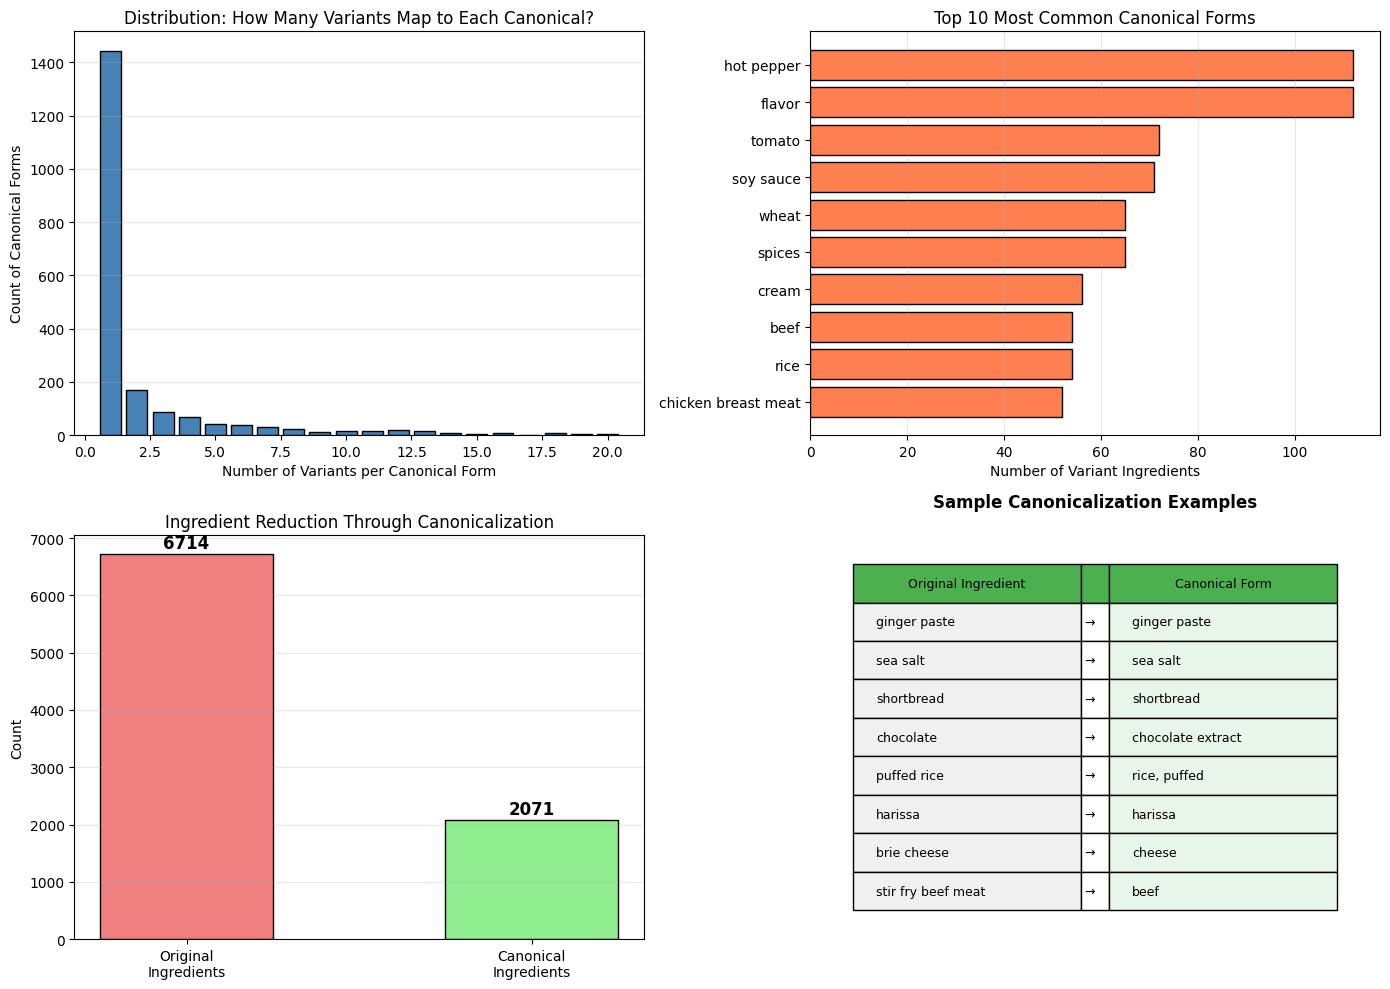

In [45]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

# Create a dataframe from ingredients_data
df = pd.DataFrame(ingredients_data)

# Add analysis metrics
print("="*80)
print("INGREDIENT CANONICALIZATION ANALYSIS")
print("="*80)

print(f"\nDataset Overview:")
print(f"   Total ingredients: {len(df)}")
print(f"   Unique original ingredients: {df['ingredient'].nunique()}")
print(f"   Unique canonical forms: {df['canonicalized'].nunique()}")
print(f"   Reduction ratio: {df['canonicalized'].nunique() / df['ingredient'].nunique():.2%}")

# Show most common canonical forms
print(f"\nTop 10 Most Common Canonical Ingredients:")
top_canonical = Counter(df['canonicalized']).most_common(10)
for i, (canonical, count) in enumerate(top_canonical, 1):
    print(f"   {i:2d}. {canonical:<30} ({count} variants)")

# Show original ingredients for top canonical forms
print(f"\nOriginal Ingredients for Top 10 Canonical Forms:")
for i, (canonical, count) in enumerate(top_canonical, 1):
    originals = df[df['canonicalized'] == canonical]['ingredient'].tolist()
    print(f"\n   {i}. '{canonical}' ({count} variants):")
    for orig in originals[:10]:
        print(f"      • {orig}")
    if len(originals) > 10:
        print(f"      ... and {len(originals) - 10} more")

# Show some examples of many-to-one mappings
print(f"\nExamples of Multiple Ingredients → Single Canonical:")
canonical_counts = df.groupby('canonicalized')['ingredient'].apply(list).to_dict()
multi_mappings = [(k, v) for k, v in canonical_counts.items() if len(v) > 1]
multi_mappings.sort(key=lambda x: len(x[1]), reverse=True)

for canonical, originals in multi_mappings[:5]:
    print(f"\n   '{canonical}' ← {len(originals)} variants:")
    for orig in originals[:5]:
        print(f"      • {orig}")
    if len(originals) > 5:
        print(f"      ... and {len(originals) - 5} more")

# Key insight: Show canonicalization patterns
print(f"\n{'='*80}")
print("CANONICALIZATION PATTERNS")
print(f"{'='*80}")

# Analyze what types of variations are being normalized
variations_found = {
    'plurality': 0,  # e.g., "tomato" vs "tomatoes"
    'articles': 0,   # e.g., "the butter" vs "butter"
    'spacing': 0,    # e.g., "soy sauce" vs "soysauce"
    'case': 0,       # e.g., "Salt" vs "salt"
}

# Count 1-to-1 vs many-to-1 mappings
one_to_one = sum(1 for k, v in canonical_counts.items() if len(v) == 1)
many_to_one = len(canonical_counts) - one_to_one

print(f"\nMapping Types:")
print(f"   One-to-one (no normalization needed): {one_to_one} ({one_to_one/len(canonical_counts)*100:.1f}%)")
print(f"   Many-to-one (normalization applied): {many_to_one} ({many_to_one/len(canonical_counts)*100:.1f}%)")

# Show effectiveness
total_original = df['ingredient'].nunique()
total_canonical = df['canonicalized'].nunique()
print(f"\nNormalization Effectiveness:")
print(f"   Removed {total_original - total_canonical} redundant variants")
print(f"   Average variants per canonical: {len(df) / total_canonical:.2f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Distribution of canonical form frequencies
ax1 = axes[0, 0]
canonical_freq = Counter(df['canonicalized'])
freq_dist = Counter(canonical_freq.values())
frequencies = sorted(freq_dist.keys())
counts = [freq_dist[f] for f in frequencies]
ax1.bar(frequencies[:20], counts[:20], color='steelblue', edgecolor='black')
ax1.set_xlabel('Number of Variants per Canonical Form')
ax1.set_ylabel('Count of Canonical Forms')
ax1.set_title('Distribution: How Many Variants Map to Each Canonical?')
ax1.grid(axis='y', alpha=0.3)

# 2. Top canonical ingredients
ax2 = axes[0, 1]
top_10_names = [name[:20] for name, _ in top_canonical]
top_10_counts = [count for _, count in top_canonical]
ax2.barh(top_10_names, top_10_counts, color='coral', edgecolor='black')
ax2.set_xlabel('Number of Variant Ingredients')
ax2.set_title('Top 10 Most Common Canonical Forms')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

# 3. Reduction effectiveness
ax3 = axes[1, 0]
categories = ['Original\nIngredients', 'Canonical\nIngredients']
values = [df['ingredient'].nunique(), df['canonicalized'].nunique()]
colors = ['lightcoral', 'lightgreen']
bars = ax3.bar(categories, values, color=colors, edgecolor='black', width=0.5)
ax3.set_ylabel('Count')
ax3.set_title('Ingredient Reduction Through Canonicalization')
ax3.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
             str(val), ha='center', va='bottom', fontweight='bold', fontsize=12)

# 4. Sample comparison table
ax4 = axes[1, 1]
ax4.axis('tight')
ax4.axis('off')
sample_data = []
for i in range(min(8, len(df))):
    orig = df.iloc[i]['ingredient']
    canon = df.iloc[i]['canonicalized']
    sample_data.append([orig[:25], '→', canon[:25]])

table = ax4.table(cellText=sample_data, 
                  colLabels=['Original Ingredient', '', 'Canonical Form'],
                  cellLoc='left',
                  loc='center',
                  colWidths=[0.4, 0.05, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)
for i in range(len(sample_data) + 1):
    if i == 0:
        table[(i, 0)].set_facecolor('#4CAF50')
        table[(i, 1)].set_facecolor('#4CAF50')
        table[(i, 2)].set_facecolor('#4CAF50')
    else:
        table[(i, 0)].set_facecolor('#f0f0f0')
        table[(i, 2)].set_facecolor('#e8f5e9')
ax4.set_title('Sample Canonicalization Examples', pad=20, fontweight='bold')

plt.tight_layout()
plt.show()

## A new approach: AI-driven Canonicalization
Relying on those methods have proven to be ineffective, so we're pivoting to a different approach.
Using OpenAI's API, we'll use generative AI to canonicalize our ingredients.

In [1]:
# We'll need this library:
!pip install openai python-dotenv

   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   --------- ------------------------------ 0.3/1.1 MB ? eta -:--:--
   --------- ------------------------------ 0.3/1.1 MB ? eta -:--:--
   ----------------------------- ---------- 0.8/1.1 MB 1.2 MB/s eta 0:00:01
   ---------------------------------------- 1.1/1.1 MB 1.4 MB/s  0:00:01

   ---------------------------------------- 0/8 [sniffio]
   ---------- ----------------------------- 2/8 [h11]
   ---------- ----------------------------- 2/8 [h11]
   ---------- ----------------------------- 2/8 [h11]
   ---------- ----------------------------- 2/8 [h11]
   ---------- ----------------------------- 2/8 [h11]
   --------------- --------------------


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
"""
This class normalizes raw ingredient strings into standard USDA-style names using the Clarifai API via the OpenAI SDK.
It batches inputs to manage rate limits, assigns temporary IDs to ensure data integrity, and uses a strict one-shot prompt 
to strip brands, quantities, and prep words. Requires CLARIFAI_API_KEY or OPENAI_API_KEY in your .env file.
"""

import os
import json
import time
from typing import List, Dict, Any
from dotenv import load_dotenv
from openai import OpenAI

load_dotenv(override=True)

class AIIngredientCanonicalizer:
    
    DEFAULT_MODEL = "https://clarifai.com/openai/chat-completion/models/gpt-oss-120b/versions/8715f5a29dc34fdb81bab0e168c5f9c2"

    def __init__(self, api_key: str = None, batch_size: int = 30):
        self.api_key = api_key or os.getenv("CLARIFAI_API_KEY") or os.getenv("OPENAI_API_KEY")
        
        if not self.api_key:
            raise ValueError("Missing API Key. Set CLARIFAI_API_KEY in your .env file.")
            
        self.api_key = self.api_key.strip()
        
        self.client = OpenAI(
            base_url="https://api.clarifai.com/v2/ext/openai/v1",
            api_key=self.api_key,
            default_headers={"Authorization": f"Key {self.api_key}"}
        )
        self.model = self.DEFAULT_MODEL
        self.batch_size = batch_size

    def process_ingredients(self, ingredients: List[str]) -> List[Dict[str, Any]]:
        valid_ingredients = [str(i).strip() for i in ingredients if i and str(i).strip()]
        unique_ingredients = list(set(valid_ingredients))
        
        print(f"Starting run. Processing {len(unique_ingredients)} unique items...")
        
        results = []
        for i in range(0, len(unique_ingredients), self.batch_size):
            batch_items = unique_ingredients[i : i + self.batch_size]
            print(f"  > Processing batch {i//self.batch_size + 1} ({len(batch_items)} items)...")
            
            batch_payload = [
                {"id": str(i + idx), "ingredient": item} 
                for idx, item in enumerate(batch_items)
            ]
            
            try:
                batch_results = self._call_llm(batch_payload)
                results.extend(batch_results)
                time.sleep(1.5) 
                
            except Exception as e:
                print(f"    Batch failed: {e}")
                results.extend([
                    {"id": p["id"], "ingredient": p["ingredient"], "canonical": "error"} 
                    for p in batch_payload
                ])

        return results

    def _call_llm(self, batch_payload: List[Dict]) -> List[Dict]:
        prompt = f"""
        SYSTEM INSTRUCTION:
        You are a Data Normalization Expert. Standardize raw food ingredient text into a clean, canonical format.

        INPUT DATA:
        {json.dumps(batch_payload)}

        TASK:
        Return a JSON array of objects. For each input item, provide:
        1. "id": Preserve exactly from input.
        2. "ingredient": Preserve exactly from input.
        3. "canonical": The standardized name (lowercase, singular, base ingredient).

        NORMALIZATION GUIDELINES:
        - Simplify: Convert specific cuts or varieties to the base ingredient (e.g., "stir fry beef meat" -> "beef").
        - Preserve Source Types: For generic bases (oil, flour, vinegar, syrup), keep the defining source but remove prep adjectives.
          (e.g., "roasted almond oil" -> "almond oil"; "balsamic vinegar" -> "balsamic vinegar"; "bleached wheat flour" -> "wheat flour").
        - Generalize: Map composites to their function (e.g., "bloody mary mix" -> "cocktail mix").
        - Clean: Remove brands, quantities, packaging (canned, frozen), and prep states (chopped, peeled, diced).
        - Correct: Fix obvious typos (e.g., "seasning" -> "seasoning").
        - Format: "canonical" must be lowercase and contain only letters, spaces, or hyphens.

        EXAMPLES:
        Input: [
            {{"id":"1", "ingredient":"Heinz Ketchup"}}, 
            {{"id":"2", "ingredient":"shredded mozzarella"}},
            {{"id":"3", "ingredient":"extra virgin olive oil"}}
        ]
        Output: [
            {{"id":"1", "ingredient":"Heinz Ketchup", "canonical":"ketchup"}},
            {{"id":"2", "ingredient":"shredded mozzarella", "canonical":"cheese"}},
            {{"id":"3", "ingredient":"extra virgin olive oil", "canonical":"olive oil"}}
        ]

        Generate the output JSON for the INPUT DATA now:
        """

        response = self.client.chat.completions.create(
            model=self.model,
            messages=[{"role": "user", "content": prompt}],
            temperature=0.0,
            stream=False
        )

        content = response.choices[0].message.content.strip()
        
        if "```" in content:
            content = content.replace("```json", "").replace("```", "")
        
        try:
            return json.loads(content)
        except json.JSONDecodeError:
            print(f"    JSON Parse Error. Raw content start: {content[:50]}...")
            raise


# 30 examples randomly sampled from ingredients.json
test_inputs = [
    "ginger",
    "sea salt",
    "chocolate",
    "puffed rice",
    "brie cheese",
    "fresh corn",
    "stir fry beef meat",
    "regular cucumber",
    "roasted almond oil",
    "daikon",
    "bloody mary mix",
    "lamb seasoning",
    "shelled shrimp",
    "green split peas",
    "tropical fruits",
    "sugar",
    "montreal steak seasning",
    "tomatoes",
    "meat stock",
    "maifun",
    "1% low-fat buttermilk",
    "buckwheat noodles",
    "crabmeat frozen",
    "purple grapes",
    "fresh prawns",
    "paprika",
    "reduced sodium tamari",
    "peeled diced tomatoes",
    "espresso powder",
    "rum raisin ice cream"
]

canon = AIIngredientCanonicalizer()
normalized_data = canon.process_ingredients(test_inputs)

# Display Results
print("\n--- Final Results ---")
print(json.dumps(normalized_data, indent=2))

Starting run. Processing 30 unique items...
  > Processing batch 1 (30 items)...

--- Final Results ---
[
  {
    "id": "0",
    "ingredient": "brie cheese",
    "canonical": "cheese"
  },
  {
    "id": "1",
    "ingredient": "reduced sodium tamari",
    "canonical": "tamari"
  },
  {
    "id": "2",
    "ingredient": "rum raisin ice cream",
    "canonical": "ice cream"
  },
  {
    "id": "3",
    "ingredient": "1% low-fat buttermilk",
    "canonical": "buttermilk"
  },
  {
    "id": "4",
    "ingredient": "ginger",
    "canonical": "ginger"
  },
  {
    "id": "5",
    "ingredient": "daikon",
    "canonical": "daikon"
  },
  {
    "id": "6",
    "ingredient": "chocolate",
    "canonical": "chocolate"
  },
  {
    "id": "7",
    "ingredient": "fresh corn",
    "canonical": "corn"
  },
  {
    "id": "8",
    "ingredient": "lamb seasoning",
    "canonical": "seasoning"
  },
  {
    "id": "9",
    "ingredient": "montreal steak seasning",
    "canonical": "seasoning"
  },
  {
    "id": "10",

This is way better. Let's convert the whole dataset this way.

In [20]:
import os
import json
import time

file_path = os.path.join(dataset_path, 'ingredients.json')

with open(file_path, 'r') as f:
    data = json.load(f)

pending_items = [item for item in data if not item.get("canonicalized")]

print(f"Total: {len(data)} | Remaining: {len(pending_items)}")

canon = AIIngredientCanonicalizer(batch_size=30)

for i in range(0, len(pending_items), 30):
    batch = pending_items[i : i + 30]
    payload = [{"id": item["id"], "ingredient": item["ingredient"]} for item in batch]
    
    print(f"Processing batch {(i // 30) + 1} ({len(batch)} items)...")
    
    max_retries = 3
    for attempt in range(max_retries):
        try:
            results = canon._call_llm(payload)
            
            results_map = {res["id"]: res.get("canonical", "error") for res in results}
            
            for item in batch:
                if item["id"] in results_map:
                    item["canonicalized"] = results_map[item["id"]]
            
            with open(file_path, 'w') as f:
                json.dump(data, f, indent=2)
                
            time.sleep(1.5)
            break
            
        except Exception as e:
            if attempt < max_retries - 1:
                print(f"Batch failed (Attempt {attempt+1}): {e}. Retrying in 10s...")
                time.sleep(10)
            else:
                print(f"Batch failed permanently after {max_retries} attempts: {e}")

print("Processing complete.")

Total: 6714 | Remaining: 6714
Processing batch 1 (30 items)...
Processing batch 2 (30 items)...
Processing batch 3 (30 items)...
Processing batch 4 (30 items)...
Processing batch 5 (30 items)...
Processing batch 6 (30 items)...
Processing batch 7 (30 items)...
Processing batch 8 (30 items)...
Processing batch 9 (30 items)...
Processing batch 10 (30 items)...
Processing batch 11 (30 items)...
Processing batch 12 (30 items)...
Processing batch 13 (30 items)...
Processing batch 14 (30 items)...
Processing batch 15 (30 items)...
Processing batch 16 (30 items)...
Processing batch 17 (30 items)...
Processing batch 18 (30 items)...
Processing batch 19 (30 items)...
Processing batch 20 (30 items)...
Processing batch 21 (30 items)...
Processing batch 22 (30 items)...
Processing batch 23 (30 items)...
Processing batch 24 (30 items)...
Processing batch 25 (30 items)...
Processing batch 26 (30 items)...
Processing batch 27 (30 items)...
Processing batch 28 (30 items)...
Processing batch 29 (30 ite

Let's analyze this as well.

Loaded 6714 ingredients
INGREDIENT CANONICALIZATION ANALYSIS

Dataset Overview:
   Total ingredients: 6714
   Unique original ingredients: 6714
   Unique canonical forms: 2229
   Reduction ratio: 33.20%

Top 10 Most Common Canonical Ingredients:
    1. cheese                         (198 variants)
    2. beef                           (120 variants)
    3. chicken                        (87 variants)
    4. pork                           (83 variants)
    5. seasoning                      (77 variants)
    6. pasta                          (69 variants)
    7. tomato                         (62 variants)
    8. bread                          (57 variants)
    9. sausage                        (57 variants)
   10. rice                           (54 variants)

Original Ingredients for Top 10 Canonical Forms:

   1. 'cheese' (198 variants):
      • brie cheese
      • grating cheese
      • Kraft Big Slice Pepper Jack Cheese Slices
      • shredded Italian cheese
      • cheese
      • ro

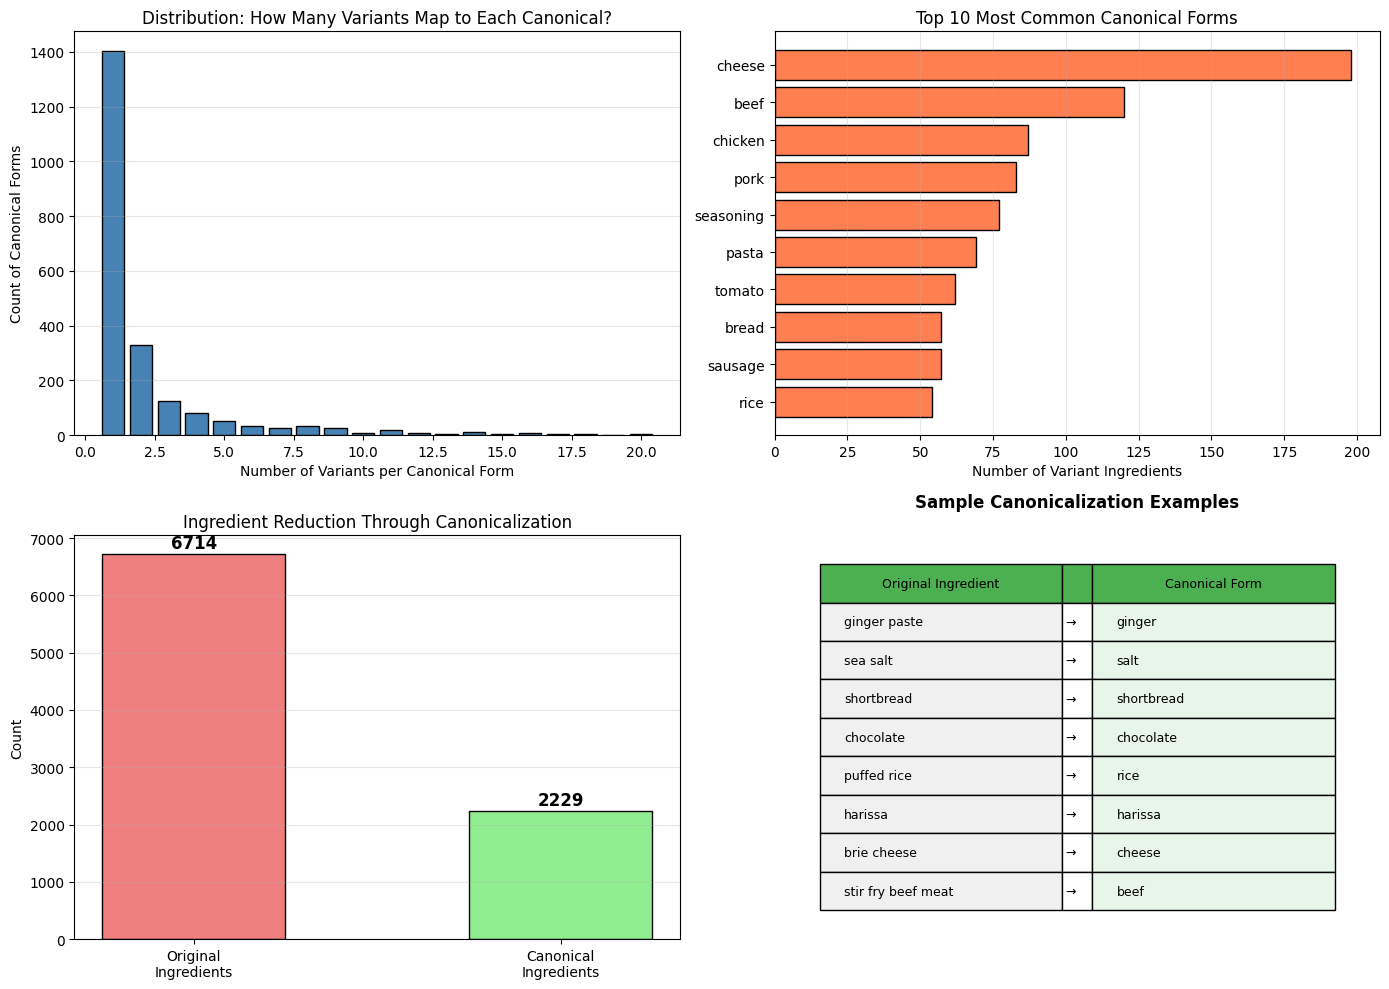

In [22]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np


# Load the ingredients data
with open(os.path.join(dataset_path, 'ingredients.json'), 'r') as f:
    ingredients_data = json.load(f)

print(f"Loaded {len(ingredients_data)} ingredients")

# Create a dataframe from ingredients_data
df = pd.DataFrame(ingredients_data)

# Add analysis metrics
print("="*80)
print("INGREDIENT CANONICALIZATION ANALYSIS")
print("="*80)

print(f"\nDataset Overview:")
print(f"   Total ingredients: {len(df)}")
print(f"   Unique original ingredients: {df['ingredient'].nunique()}")
print(f"   Unique canonical forms: {df['canonicalized'].nunique()}")
print(f"   Reduction ratio: {df['canonicalized'].nunique() / df['ingredient'].nunique():.2%}")

# Show most common canonical forms
print(f"\nTop 10 Most Common Canonical Ingredients:")
top_canonical = Counter(df['canonicalized']).most_common(10)
for i, (canonical, count) in enumerate(top_canonical, 1):
    print(f"   {i:2d}. {canonical:<30} ({count} variants)")

# Show original ingredients for top canonical forms
print(f"\nOriginal Ingredients for Top 10 Canonical Forms:")
for i, (canonical, count) in enumerate(top_canonical, 1):
    originals = df[df['canonicalized'] == canonical]['ingredient'].tolist()
    print(f"\n   {i}. '{canonical}' ({count} variants):")
    for orig in originals[:10]:
        print(f"      • {orig}")
    if len(originals) > 10:
        print(f"      ... and {len(originals) - 10} more")

# Show some examples of many-to-one mappings
print(f"\nExamples of Multiple Ingredients → Single Canonical:")
canonical_counts = df.groupby('canonicalized')['ingredient'].apply(list).to_dict()
multi_mappings = [(k, v) for k, v in canonical_counts.items() if len(v) > 1]
multi_mappings.sort(key=lambda x: len(x[1]), reverse=True)

for canonical, originals in multi_mappings[:5]:
    print(f"\n   '{canonical}' ← {len(originals)} variants:")
    for orig in originals[:5]:
        print(f"      • {orig}")
    if len(originals) > 5:
        print(f"      ... and {len(originals) - 5} more")

# Key insight: Show canonicalization patterns
print(f"\n{'='*80}")
print("CANONICALIZATION PATTERNS")
print(f"{'='*80}")

# Analyze what types of variations are being normalized
variations_found = {
    'plurality': 0,  # e.g., "tomato" vs "tomatoes"
    'articles': 0,   # e.g., "the butter" vs "butter"
    'spacing': 0,    # e.g., "soy sauce" vs "soysauce"
    'case': 0,       # e.g., "Salt" vs "salt"
}

# Count 1-to-1 vs many-to-1 mappings
one_to_one = sum(1 for k, v in canonical_counts.items() if len(v) == 1)
many_to_one = len(canonical_counts) - one_to_one

print(f"\nMapping Types:")
print(f"   One-to-one (no normalization needed): {one_to_one} ({one_to_one/len(canonical_counts)*100:.1f}%)")
print(f"   Many-to-one (normalization applied): {many_to_one} ({many_to_one/len(canonical_counts)*100:.1f}%)")

# Show effectiveness
total_original = df['ingredient'].nunique()
total_canonical = df['canonicalized'].nunique()
print(f"\nNormalization Effectiveness:")
print(f"   Removed {total_original - total_canonical} redundant variants")
print(f"   Average variants per canonical: {len(df) / total_canonical:.2f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Distribution of canonical form frequencies
ax1 = axes[0, 0]
canonical_freq = Counter(df['canonicalized'])
freq_dist = Counter(canonical_freq.values())
frequencies = sorted(freq_dist.keys())
counts = [freq_dist[f] for f in frequencies]
ax1.bar(frequencies[:20], counts[:20], color='steelblue', edgecolor='black')
ax1.set_xlabel('Number of Variants per Canonical Form')
ax1.set_ylabel('Count of Canonical Forms')
ax1.set_title('Distribution: How Many Variants Map to Each Canonical?')
ax1.grid(axis='y', alpha=0.3)

# 2. Top canonical ingredients
ax2 = axes[0, 1]
top_10_names = [name[:20] for name, _ in top_canonical]
top_10_counts = [count for _, count in top_canonical]
ax2.barh(top_10_names, top_10_counts, color='coral', edgecolor='black')
ax2.set_xlabel('Number of Variant Ingredients')
ax2.set_title('Top 10 Most Common Canonical Forms')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

# 3. Reduction effectiveness
ax3 = axes[1, 0]
categories = ['Original\nIngredients', 'Canonical\nIngredients']
values = [df['ingredient'].nunique(), df['canonicalized'].nunique()]
colors = ['lightcoral', 'lightgreen']
bars = ax3.bar(categories, values, color=colors, edgecolor='black', width=0.5)
ax3.set_ylabel('Count')
ax3.set_title('Ingredient Reduction Through Canonicalization')
ax3.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
             str(val), ha='center', va='bottom', fontweight='bold', fontsize=12)

# 4. Sample comparison table
ax4 = axes[1, 1]
ax4.axis('tight')
ax4.axis('off')
sample_data = []
for i in range(min(8, len(df))):
    orig = df.iloc[i]['ingredient']
    canon = df.iloc[i]['canonicalized']
    sample_data.append([orig[:25], '→', canon[:25]])

table = ax4.table(cellText=sample_data, 
                  colLabels=['Original Ingredient', '', 'Canonical Form'],
                  cellLoc='left',
                  loc='center',
                  colWidths=[0.4, 0.05, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)
for i in range(len(sample_data) + 1):
    if i == 0:
        table[(i, 0)].set_facecolor('#4CAF50')
        table[(i, 1)].set_facecolor('#4CAF50')
        table[(i, 2)].set_facecolor('#4CAF50')
    else:
        table[(i, 0)].set_facecolor('#f0f0f0')
        table[(i, 2)].set_facecolor('#e8f5e9')
ax4.set_title('Sample Canonicalization Examples', pad=20, fontweight='bold')

plt.tight_layout()
plt.show()